In [ ]:
# libraries
import os
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# models
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
%run "/content/gdrive/MyDrive/Colab Notebooks/UNIR/2_Cuatrimestre/TFM/3_utils/PY_utils.ipynb"

### 1. Load images from dataset
The dataset is split in train (80%), validation (10%) and test (10%)

In [ ]:
# unzip file
!unzip "/content/gdrive/MyDrive/Colab Notebooks/UNIR/2_Cuatrimestre/TFM/1_modeling/dataset_fer2013.zip"

Streaming output truncated to the last 5000 lines.
 extracting: train/surprise/Training_60655724.jpg  
 extracting: train/surprise/Training_60659358.jpg  
 extracting: train/surprise/Training_6078277.jpg  
 extracting: train/surprise/Training_60785981.jpg  
 extracting: train/surprise/Training_60789084.jpg  
 extracting: train/surprise/Training_60800200.jpg  
 extracting: train/surprise/Training_60807076.jpg  
 extracting: train/surprise/Training_60827534.jpg  
 extracting: train/surprise/Training_60852297.jpg  
 extracting: train/surprise/Training_60859384.jpg  
 extracting: train/surprise/Training_60925134.jpg  
 extracting: train/surprise/Training_60936694.jpg  
 extracting: train/surprise/Training_60954776.jpg  
 extracting: train/surprise/Training_61021692.jpg  
 extracting: train/surprise/Training_61026828.jpg  
 extracting: train/surprise/Training_61064218.jpg  
 extracting: train/surprise/Training_61126060.jpg  
 extracting: train/surprise/Training_6113864.jpg  
 extracting: tr

In [ ]:
# directories
ROOT = "/content/gdrive/MyDrive/Colab Notebooks/UNIR/2_Cuatrimestre/TFM/1_modeling/"
TRAIN_PATH = "/content/train"
VAL_PATH = "/content/validation"
TEST_PATH = "/content/test"

# target size of images
TARGET_SIZE = 48

# batch size
BATCH_SIZE = 128

# map labels to emotions
map_emotions = {0: "angry", 1:"disgust", 2:"fear", 3: "happy",
                4: "neutral", 5: "sad", 6:"surprise"}

### 2. Load and transform dataset
Images are transformed from color (NxNx3) to grayscale (NxNx1) and scaled to (0, 1). One-hot encoding is applied to labels. Data augmentation technique is used.

In [ ]:
# load dataset
train_set = data_loader_tf_dataset(TRAIN_PATH, BATCH_SIZE, TARGET_SIZE, augmentation=True, shuffle=True)
val_set = data_loader_tf_dataset(VAL_PATH, BATCH_SIZE, TARGET_SIZE, augmentation=False, shuffle=False)
test_set = data_loader_tf_dataset(TEST_PATH, BATCH_SIZE, TARGET_SIZE, augmentation=False, shuffle=False)

Found 28709 files belonging to 7 classes.
Found 3587 files belonging to 7 classes.
Found 3591 files belonging to 7 classes.


### 3. Training
To train the classifier we utilize a neural network architecture considering  convolutional and fully connected layers.

#### Define CNN architecture

In [ ]:
# define architecture
DROPOUT = 0.4
OUTPUT_SIZE = len(map_emotions)

# define sequential model
model = keras.models.Sequential()
# 1 convolution layer
model.add(layers.BatchNormalization(input_shape=(TARGET_SIZE, TARGET_SIZE, 1)))
model.add(layers.Conv2D(32, (3, 3), input_shape=(TARGET_SIZE, TARGET_SIZE, 1)))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(DROPOUT))
# 2 convolution layer
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(3, 2))
model.add(layers.Dropout(DROPOUT))
# 3 convolution layer
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(3, 2))
model.add(layers.Dropout(DROPOUT))
# 4 convolution layer
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(3, 2))
model.add(layers.Dropout(DROPOUT))
# flatten
model.add(layers.Flatten())
# 1 fully connected hidden layer
model.add(layers.Dense(units=1024))
model.add(layers.Activation("relu"))
model.add(layers.Dropout(DROPOUT + 0.1))
model.add(layers.BatchNormalization())
# 2 fully connected hidden layer
model.add(layers.Dense(units=512))
model.add(layers.Activation("relu"))
model.add(layers.Dropout(DROPOUT + 0.1))
model.add(layers.BatchNormalization())
# output layer
model.add(layers.Dense(units=OUTPUT_SIZE, activation="softmax"))

In [ ]:
# architecture summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 48, 48, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)       

#### Compile and train classifier

In [ ]:
# define loss, optimizer and monitoring metrics
loss_function = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.AdamW()
metrics = [keras.metrics.CategoricalAccuracy(name="Accuracy"),
           keras.metrics.AUC(curve="ROC", name="AUC_ROC", multi_label=True),
           keras.metrics.AUC(curve="PR", name="AUC_PR", multi_label=True)]

# class weights
class_weights = {0: 1, 1: 1.2, 2: 1.2, 3: 1, 4: 0.9, 5: 1.1, 6: 1}

# compile model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=metrics)

In [ ]:
# define number of epochs and batch size
N_EPOCHS = 100

# train classifier
history = model.fit(train_set, epochs=N_EPOCHS,
                    batch_size=BATCH_SIZE, validation_data=val_set,
                    class_weight=class_weights)

Epoch 1/100
225/225 [==============================] - 30s 58ms/step - loss: 2.2327 - Accuracy: 0.2039 - AUC_ROC: 0.5299 - AUC_PR: 0.1574 - val_loss: 3.1909 - val_Accuracy: 0.1717 - val_AUC_ROC: 0.5124 - val_AUC_PR: 0.1505
Epoch 2/100
225/225 [==============================] - 4s 18ms/step - loss: 1.9275 - Accuracy: 0.2350 - AUC_ROC: 0.5555 - AUC_PR: 0.1696 - val_loss: 2.2953 - val_Accuracy: 0.1868 - val_AUC_ROC: 0.5354 - val_AUC_PR: 0.1637
Epoch 3/100
225/225 [==============================] - 5s 21ms/step - loss: 1.8604 - Accuracy: 0.2577 - AUC_ROC: 0.5830 - AUC_PR: 0.1856 - val_loss: 1.8333 - val_Accuracy: 0.2601 - val_AUC_ROC: 0.5965 - val_AUC_PR: 0.2054
Epoch 4/100
225/225 [==============================] - 4s 19ms/step - loss: 1.8279 - Accuracy: 0.2752 - AUC_ROC: 0.6017 - AUC_PR: 0.2002 - val_loss: 1.7313 - val_Accuracy: 0.3047 - val_AUC_ROC: 0.6274 - val_AUC_PR: 0.2327
Epoch 5/100
225/225 [==============================] - 4s 18ms/step - loss: 1.8059 - Accuracy: 0.2867 - AUC_ROC

#### Save model

In [ ]:
# save model
MODEL_NAME = "1_fer_da"
SAVE_PATH = ROOT + "{}/".format(MODEL_NAME)
FILE_NAME = MODEL_NAME + ".h5"
model.save(SAVE_PATH + FILE_NAME, overwrite=True, save_format="h5")

### 4. Metrics

#### Learning curves

In [ ]:
# save learning curves
FILE_NAME = MODEL_NAME + "_lc.csv"
df = pd.DataFrame(history.history)
df.to_csv(SAVE_PATH + FILE_NAME, index=False)

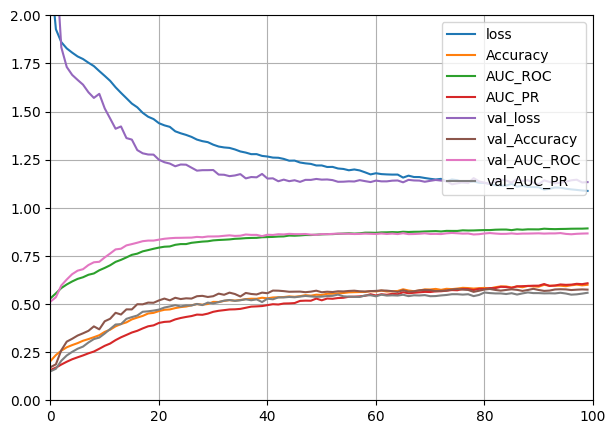

In [ ]:
# learning curves
learning_curve(history, N_EPOCHS)

#### Confusion matrix: validation set


29/29 [==============================] - 0s 3ms/step
Matrix de confusión



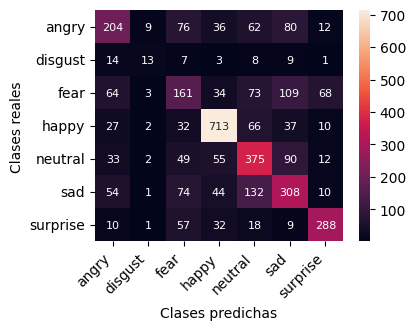



Reporte clasificacion:

              precision    recall  f1-score   support

       angry       0.50      0.43      0.46       479
     disgust       0.42      0.24      0.30        55
        fear       0.35      0.31      0.33       512
       happy       0.78      0.80      0.79       887
     neutral       0.51      0.61      0.56       616
         sad       0.48      0.49      0.49       623
    surprise       0.72      0.69      0.71       415

    accuracy                           0.57      3587
   macro avg       0.54      0.51      0.52      3587
weighted avg       0.57      0.57      0.57      3587



In [ ]:
# get true and predicted labels
confusion_matrix_report(model, val_set, map_emotions)

#### Confusion matrix: test set

29/29 [==============================] - 0s 5ms/step
Matrix de confusión



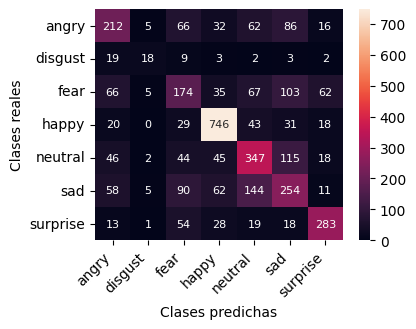



Reporte clasificacion:

              precision    recall  f1-score   support

       angry       0.49      0.44      0.46       479
     disgust       0.50      0.32      0.39        56
        fear       0.37      0.34      0.36       512
       happy       0.78      0.84      0.81       887
     neutral       0.51      0.56      0.53       617
         sad       0.42      0.41      0.41       624
    surprise       0.69      0.68      0.69       416

    accuracy                           0.57      3591
   macro avg       0.54      0.51      0.52      3591
weighted avg       0.56      0.57      0.56      3591



In [ ]:
# get true and predicted labels
confusion_matrix_report(model, test_set, map_emotions)